# 08. Natural Language Processing with TensorFlow

Natural language is a broad term but it cover Text & Speech (amongst other)

## What we're going to cover

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

## Get helper functions

The script containing our helper functions can be [found on GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py).

In [1]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-03-26 21:02:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-03-26 21:02:01 (82.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, plot_loss_curves, compare_historys

## Download a text dataset

We'll be using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) dataset from Kaggle which contains text-based Tweets about natural disasters.

In [3]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2025-03-26 21:02:12--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   719KB/s    in 0.8s    

2025-03-26 21:02:13 (719 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:
* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing a text dataset

You might come across text datasets in many different formats. Aside from CSV files, you'll probably encounter `.txt` files and `.json` files too.
For working with these type of files, I'd recommend reading the two following articles by RealPython:
* [How to Read and Write Files in Python](https://realpython.com/read-write-files-python/)
* [Working with JSON Data in Python](https://realpython.com/python-json/)

In [4]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df.target.value_counts()

,count
target,
0,4342
1,3271


Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 60% negative class (`target = 0`) and 40% positive class (`target = 1`).

Where,

* `1` = a real disaster Tweet
* `0` = not a real disaster Tweet

In [8]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
@TfLBusAlerts @TfLBusAlerts The Drive in Ilford closed both ways while emergency services deal with a call out. Buses are now stuck.

---

Target: 0 (not real disaster)
Text:
ÛÏStretcher in 5 min // Speaker DeckÛ http://t.co/7qPG80uD7v

---

Target: 1 (real disaster)
Text:
This past week has been an absolute whirlwind.... Athens bound

---

Target: 0 (not real disaster)
Text:
@tyleroakley IM SCREAMING

---

Target: 1 (real disaster)
Text:
Does anyone know why #murfreesboro #walmart was evacuated this evening? @dnj_com

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [11]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
  1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

> 🤔 **Question:** What level of tokenzation should I use? What embedding should should I choose?

It depends on your problem. You could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. You might even want to try stacking them (e.g. combining the outputs of your embedding layers using [`tf.keras.layers.concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)).

If you're looking for pre-trained word embeddings, [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/), [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and many of the options available on [TensorFlow Hub](https://tfhub.dev/s?module-type=text-embedding) are great places to start.

### Text vectorization (tokenization)

To tokenize our words, we'll use the preprocessing layer [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`.


For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values. We'll use `10,000`.

For the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set.

In [13]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [15]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [16]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

We set `output_sequence_length=15`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15.

In [17]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
http://t.co/FhI4qBpwFH @FredOlsenCruise Please take the #FaroeIslands off your itinerary until the mass murder of dolphins &amp; whales stops.      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,    1,  170,  167,    2, 3860,  102,   33,    1,  293,    2,
         157,  315,    6,    1]])>

We can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [18]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
Bottom 5 least common words: [np.str_('pages'), np.str_('paeds'), np.str_('pads'), np.str_('padres'), np.str_('paddytomlinson1')]


### Creating an Embedding using an Embedding Layer

The powerful thing about an embedding is it can be learned during training, ie it can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

In [19]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             # input_length=max_length, # how long is each input, DEPRECATED
                             name="embedding_1")

embedding

<Embedding name=embedding_1, built=False>

In [20]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
ÛÏ@FDNY: This morning #FDNY responded to a sinkhole in #Brooklyn. Units remain on-scene with @NYCBuildings &amp; others. http://t.co/M78ir0IK01Û      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01913718, -0.043511  ,  0.00945742, ...,  0.00092707,
         -0.01793537,  0.0478642 ],
        [-0.0254892 ,  0.03093443, -0.01837854, ..., -0.00815134,
         -0.0028636 ,  0.01323945],
        [ 0.03022439, -0.00573875,  0.04825673, ...,  0.03530155,
         -0.00467162,  0.01347244],
        ...,
        [ 0.01992526,  0.03655449,  0.02519358, ...,  0.01622435,
          0.04911411,  0.04389736],
        [ 0.00709367,  0.04779075, -0.02317283, ..., -0.02436246,
         -0.00242843, -0.03159627],
        [ 0.01992526,  0.03655449,  0.02519358, ...,  0.01622435,
          0.04911411,  0.04389736]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

In [21]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.01913718, -0.043511  ,  0.00945742,  0.03675462, -0.0422665 ,
       -0.0258118 , -0.02747637, -0.01213691, -0.03928757,  0.01162821,
        0.03107337, -0.0475266 ,  0.04960046,  0.04057992, -0.01846237,
       -0.02254382,  0.0331926 , -0.03954148,  0.04770673,  0.02367817,
        0.03779006, -0.00752363,  0.01388815, -0.00779678,  0.04481938,
        0.00929091,  0.03640238, -0.03471066,  0.01652515, -0.04351329,
       -0.02848772,  0.04265466,  0.02910426,  0.04731459,  0.02636575,
        0.01045548, -0.04998222,  0.02086211,  0.00449032, -0.03126987,
       -0.04871907,  0.02676496, -0.00400486, -0.03249999, -0.01357741,
        0.03430626,  0.04802111, -0.03113711,  0.03522767, -0.02476211,
        0.04049229,  0.03545722,  0.01283182, -0.04253147,  0.00846837,
        0.00850941, -0.03278007,  0.03651079, -0.00047426, -0.00847499,
       -0.0429531 ,  0.00359473,  0.03738035, -0.01419865,  0.00035853,
       -0.041620

## Modelling a text dataset


We'll be building the following models :
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

### Model 0: Getting a baseline

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).

> 📖 **Reading:** The ins and outs of TF-IDF algorithm is beyond the scope of this notebook, however, the curious reader is encouraged to check out the [Scikit-Learn documentation for more](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score


In [25]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [26]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

In [27]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [28]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [29]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6307 - loss: 0.6499 - val_accuracy: 0.7559 - val_loss: 0.5337
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8082 - loss: 0.4663 - val_accuracy: 0.7913 - val_loss: 0.4738
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8525 - loss: 0.3623 - val_accuracy: 0.7940 - val_loss: 0.4617
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8865 - loss: 0.2961 - val_accuracy: 0.7874 - val_loss: 0.4679
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9070 - loss: 0.2473 - val_accuracy: 0.7756 - val_loss: 0.4836


In [31]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7668 - loss: 0.5158


[0.4836309552192688, 0.7755905389785767]

In [32]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[0.323362  ],
       [0.73337674],
       [0.99759007],
       [0.19132254],
       [0.09278088],
       [0.9457463 ],
       [0.89726937],
       [0.99444467],
       [0.96150047],
       [0.3892801 ]], dtype=float32)

In [33]:
# Turn prediction probabilities into single-dimension tensor of floats through round. Tradeoff at 0.5 but not always the best, depends on the case here it's our choice.
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [34]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.55905511811024,
 'precision': 0.7783607884132258,
 'recall': 0.7755905511811023,
 'f1': 0.7730920642120305}

In [35]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 77.56, Difference: -1.71
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


## Recurrent Neural Networks (RNN's)

When an RNN looks at a sequence of text, the patterns it learns are continually updated based on the order of the sequence.

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** such as image classification.
* **One to many:** such as image captioning.
* **Many to one:** such as text classification.
* **Many to many:** such as machine translation or speech to text.

When you come across RNN's in the wild, you'll most likely come across variants of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

> 📖 **Resources:**
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.


### Model 2: LSTM

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

> 🔑 **Note:** Reading the documentation for the [TensorFlow LSTM layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM), you'll find a plethora of parameters. Many of these have been tuned to make sure they compute as fast as possible. The main ones you'll be looking to adjust are `units` (number of hidden units) and `return_sequences` (set this to `True` when stacking LSTM or other recurrent layers).

Our model is going to take on a very similar structure to `model_1`:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (`model_2_embedding`) for our model. The `text_vectorizer` layer can be reused since it doesn't get updated during training.

In [36]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [37]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6711 - loss: 0.5817 - val_accuracy: 0.7743 - val_loss: 0.4609
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8667 - loss: 0.3312 - val_accuracy: 0.7677 - val_loss: 0.5009
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9118 - loss: 0.2333 - val_accuracy: 0.7638 - val_loss: 0.5576
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9398 - loss: 0.1704 - val_accuracy: 0.7690 - val_loss: 0.5729
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9563 - loss: 0.1340 - val_accuracy: 0.7546 - val_loss: 0.6825


In [40]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


((762, 1),
 array([[0.03150158],
        [0.89079344],
        [0.99697   ],
        [0.13289821],
        [0.00977341],
        [0.9984565 ],
        [0.6912249 ],
        [0.9994842 ],
        [0.9967212 ],
        [0.7723364 ]], dtype=float32))

In [41]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [42]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.45931758530183,
 'precision': 0.7554721118840667,
 'recall': 0.7545931758530183,
 'f1': 0.7525708541042813}

In [43]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.46, Difference: -3.81
Baseline precision: 0.81, New precision: 0.76, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


### Model 3: GRU

The GRU cell has similar features to an LSTM cell but has less parameters.

> 📖 **Resource:** A full explanation of the GRU cell is beyond the scope of this noteook but I'd suggest the following resources to learn more:
* [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) Wikipedia page
* [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) by Simeon Kostadinov

To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

In [44]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [45]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6477 - loss: 0.6009 - val_accuracy: 0.7782 - val_loss: 0.4590
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8615 - loss: 0.3381 - val_accuracy: 0.7677 - val_loss: 0.5005
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9099 - loss: 0.2339 - val_accuracy: 0.7533 - val_loss: 0.5752
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9366 - loss: 0.1721 - val_accuracy: 0.7690 - val_loss: 0.6047
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9596 - loss: 0.1301 - val_accuracy: 0.7677 - val_loss: 0.6427


In [48]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


((762, 1),
 array([[0.1201478 ],
        [0.93017465],
        [0.9943025 ],
        [0.10931194],
        [0.0103007 ],
        [0.98915637],
        [0.44734567],
        [0.99686426],
        [0.994961  ],
        [0.46314833]], dtype=float32))

In [49]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [50]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7715939358671309,
 'recall': 0.7677165354330708,
 'f1': 0.7645288433434009}

In [51]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


### Model 4: Bidirectonal RNN model

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Once again, TensorFlow helps us out by providing the [`tensorflow.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) class. We can use the `Bidirectional` class to wrap our existing RNNs, instantly making them bidirectional.

> 🔑 **Note:** You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

In [52]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [53]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6753 - loss: 0.5813 - val_accuracy: 0.7848 - val_loss: 0.4609
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8644 - loss: 0.3291 - val_accuracy: 0.7638 - val_loss: 0.5047
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9128 - loss: 0.2246 - val_accuracy: 0.7598 - val_loss: 0.5682
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9463 - loss: 0.1543 - val_accuracy: 0.7533 - val_loss: 0.6403
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9608 - loss: 0.1180 - val_accuracy: 0.7585 - val_loss: 0.7172


In [56]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


array([[0.21860954],
       [0.92227715],
       [0.9988932 ],
       [0.10282769],
       [0.00313559],
       [0.9945868 ],
       [0.37526095],
       [0.9993067 ],
       [0.99893206],
       [0.8893046 ]], dtype=float32)

In [57]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [58]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.8530183727034,
 'precision': 0.7582012033831707,
 'recall': 0.7585301837270341,
 'f1': 0.7582816474189752}

In [59]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 75.85, Difference: -3.41
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Convolutional Neural Networks for Text

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following:

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.

> 📖 **Resource:** The intuition here is explained succinctly in the paper [*Understanding Convolutional Neural Networks for Text Classification*](https://www.aclweb.org/anthology/W18-5408.pdf), where they state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams.
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

### Model 5: Conv1D

In [60]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 11, 32)              │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6571 - loss: 0.6296 - val_accuracy: 0.7822 - val_loss: 0.4671
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8495 - loss: 0.3737 - val_accuracy: 0.7808 - val_loss: 0.4739
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9078 - loss: 0.2387 - val_accuracy: 0.7861 - val_loss: 0.5277
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9494 - loss: 0.1525 - val_accuracy: 0.7900 - val_loss: 0.5884
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9648 - loss: 0.1064 - val_accuracy: 0.7822 - val_loss: 0.6461


In [62]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[0.7431696 ],
       [0.8373529 ],
       [0.99918956],
       [0.05720407],
       [0.00358696],
       [0.9841962 ],
       [0.9559522 ],
       [0.9985216 ],
       [0.99978274],
       [0.2564757 ]], dtype=float32)

In [63]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [64]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.21522309711287,
 'precision': 0.7843528649827862,
 'recall': 0.7821522309711286,
 'f1': 0.7800522271093586}

In [65]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.22, Difference: -1.05
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Using Pretrained Embeddings (transfer learning for NLP)

A common practice is to leverage pretrained embeddings through **transfer learning**.

For our next model, instead of using our own embedding layer, we're going to use a pretrained embedding layer.

We're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).



### Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

In [66]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors.

We can convert the TensorFlow Hub USE module into a Keras layer using the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

In [67]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor), trainable = True to fine-tune.
                                        name="USE")

In [68]:
import tf_keras # To use the KerasLayer in a Sequential we need this library and not the tf.keras one

# Create model using the Sequential API
model_6 = tf_keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  tf_keras.layers.Dense(64, activation="relu"),
  tf_keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf_keras.optimizers.Adam(), # Must be changed from tf.keras.optimizers to tf_keras.optimizers
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [69]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 6s 13ms/step - loss: 0.5026 - accuracy: 0.7882 - val_loss: 0.4497 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4154 - accuracy: 0.8140 - val_loss: 0.4386 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4009 - accuracy: 0.8208 - val_loss: 0.4340 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3936 - accuracy: 0.8253 - val_loss: 0.4287 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3872 - accuracy: 0.8295 - val_loss: 0.4302 - val_accuracy: 0.8163


In [70]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.15211076],
       [0.74550337],
       [0.9855128 ],
       [0.19044125],
       [0.7257337 ],
       [0.67430985],
       [0.9785169 ],
       [0.97409046],
       [0.91518015],
       [0.08637379]], dtype=float32)

In [71]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [72]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [73]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.63, Difference: 2.36
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [74]:
# split the already split train_sentences/train_labels
import numpy as np
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [75]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [76]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

,count
0,415
1,271


We'll clone our `model_6` using the [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [77]:
# Clone model_6 but reset weights
model_7 = tf_keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [78]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 4s 43ms/step - loss: 0.6679 - accuracy: 0.6706 - val_loss: 0.6504 - val_accuracy: 0.6890
Epoch 2/5
22/22 [==============================] - 0s 20ms/step - loss: 0.5954 - accuracy: 0.8047 - val_loss: 0.5953 - val_accuracy: 0.7323
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5193 - accuracy: 0.8251 - val_loss: 0.5421 - val_accuracy: 0.7638
Epoch 4/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4546 - accuracy: 0.8353 - val_loss: 0.5088 - val_accuracy: 0.7730
Epoch 5/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4109 - accuracy: 0.8382 - val_loss: 0.4911 - val_accuracy: 0.7756


In [79]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.23452163],
       [0.78875333],
       [0.8914575 ],
       [0.28887   ],
       [0.57250476],
       [0.8253083 ],
       [0.8196191 ],
       [0.8280654 ],
       [0.8261286 ],
       [0.12479927]], dtype=float32)

In [80]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 0.7806291092122156,
 'recall': 0.7755905511811023,
 'f1': 0.7721994170090104}

In [82]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.56, Difference: -1.71
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


## Comparing the performance of each of our models

In [83]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,77.559055,0.778361,0.775591,0.773092
lstm,75.459318,0.755472,0.754593,0.752571
gru,76.771654,0.771594,0.767717,0.764529
bidirectional,75.853018,0.758201,0.758530,0.758282
conv1d,78.215223,0.784353,0.782152,0.780052
tf_hub_sentence_encoder,81.627297,0.818446,0.816273,0.814808
tf_hub_10_percent_data,77.559055,0.780629,0.775591,0.772199


In [84]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

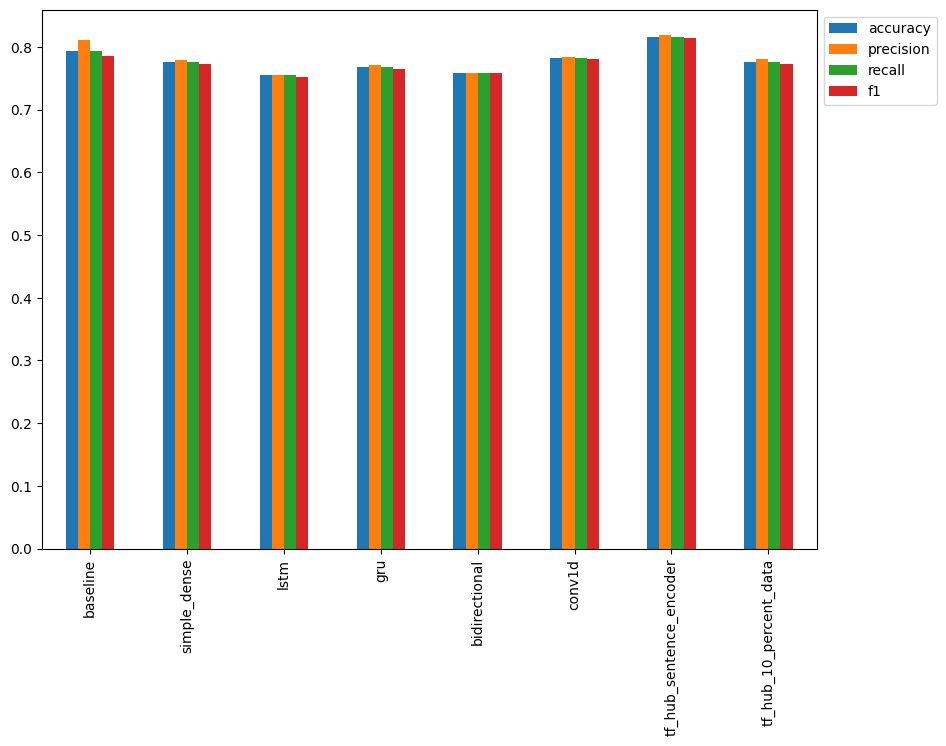

In [85]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

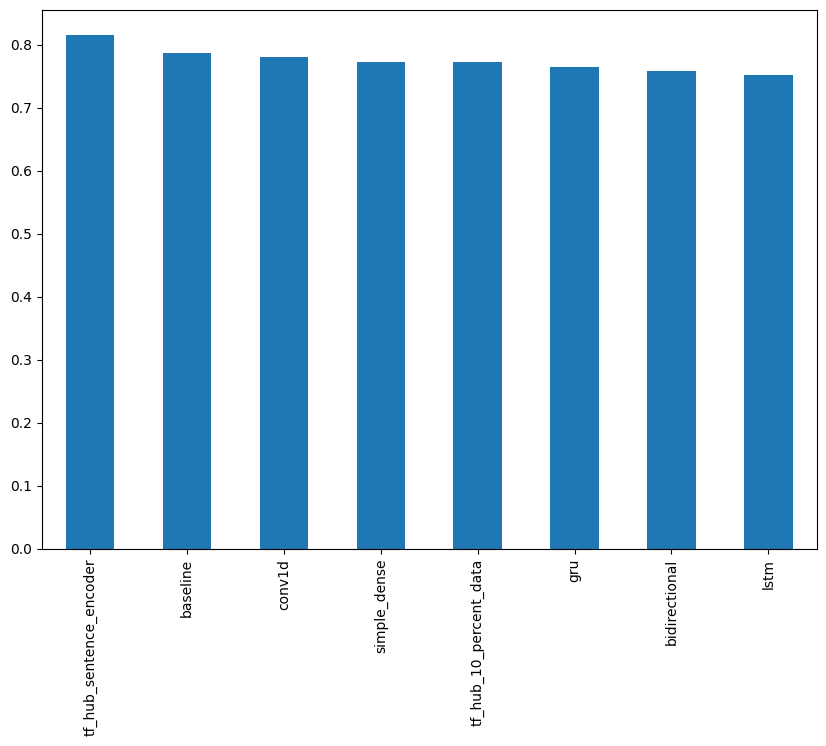

In [86]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Combining our models (model ensembling/stacking)

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.

There are a few of ways we can combine our models for classification :
1. **Averaging** - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. **Majority vote (mode)**
3. **Model stacking** - Take the outputs of each of your chosen models and use them as inputs to another model.

> 📖 **Resource:** The above methods for model stacking/ensembling were adapted from Chapter 6 of the [Machine Learning Engineering Book](http://www.mlebook.com/wiki/doku.php) by Andriy Burkov.

In [87]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [88]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.34645669291339,
 'precision': 0.783150063178731,
 'recall': 0.7834645669291339,
 'f1': 0.7830774138506092}

In [118]:
ensemble_results['accuracy'] = ensemble_results['accuracy']/100

{'accuracy': 0.7834645669291339,
 'precision': 0.783150063178731,
 'recall': 0.7834645669291339,
 'f1': 0.7830774138506092}

In [119]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [121]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.775591,0.778361,0.775591,0.773092
lstm,0.754593,0.755472,0.754593,0.752571
gru,0.767717,0.771594,0.767717,0.764529
bidirectional,0.758530,0.758201,0.758530,0.758282
conv1d,0.782152,0.784353,0.782152,0.780052
tf_hub_sentence_encoder,0.816273,0.818446,0.816273,0.814808
tf_hub_10_percent_data,0.775591,0.780629,0.775591,0.772199
ensemble_results,0.783465,0.783150,0.783465,0.783077


## Saving and loading a trained model

In [92]:
# Save TF Hub Sentence Encoder model to keras format
model_6.save("model_6.keras")

If you save a model as a `keras`, when loading it back in, you need to let [TensorFlow know about any custom objects you've used](https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects) (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

In [93]:
# Load model with custom Hub Layer
loaded_model_6 = tf_keras.models.load_model("model_6.keras",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [94]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 15ms/step - loss: 0.4302 - accuracy: 0.8163


[0.43021097779273987, 0.8162729740142822]

## Finding the most wrong examples

One of the best ways to inspect your data is to find the samples it got *most* wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

* If our best model still isn't perfect, what examples is it getting wrong?
* Which ones are the *most* wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [95]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.152111
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.745503
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985513
3,@camilacabello97 Internally and externally scr...,1,0.0,0.190441
4,Radiation emergency #preparedness starts with ...,1,1.0,0.725734


In [96]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914366
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.843470
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.843149
759,FedEx will no longer transport bioterror patho...,0,1.0,0.841604
628,@noah_anyname That's where the concentration c...,0,1.0,0.834291
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.818999
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.789525
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.783993
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.769547
144,The Sound of Arson,0,1.0,0.762017


In [97]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9143657684326172
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8434702754020691
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8431494235992432
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8416035771369934
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.834290623664856
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8189988732337952
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pro

In [98]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.056616656482219696
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.05591674521565437
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.054122358560562134
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.053825851529836655
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.04799259081482887
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.046233970671892166
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.0419393

## Making predictions on the test dataset

In [99]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 52ms/step
Pred: 0, Prob: 0.17690534889698029
Text:
Remove http://t.co/77b2rNRTt7 Browser Hijacker - How t... http://t.co/Wff7X3B6KT

----

1/1 [==============================] - 0s 46ms/step
Pred: 0, Prob: 0.10908883810043335
Text:
I can't take advantage of Smith Micro's deals right now because exploded car (hint hint shironu_akaineko AT... http://t.co/qbCTxPwhYP

----

1/1 [==============================] - 0s 54ms/step
Pred: 0, Prob: 0.21325120329856873
Text:
?please read casualty fans?
Let us know &amp; help spread the word by retweeting! DM me or @ScriptetteSar for more info?? http://t.co/HDrBTJRoHb

----

1/1 [==============================] - 0s 55ms/step
Pred: 0, Prob: 0.15436239540576935
Text:
MY SCHOOL IS INUNDATED and they wont let us go home til 4pm help

----

1/1 [==============================] - 0s 53ms/step
Pred: 1, Prob: 0.7199615836143494
Text:
...//..// whao.. 12000 Nigerian refugees repatriated from Cameroon http://t.co/aVwE

## Predicting on Tweets from the wild

In [100]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [101]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [102]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 33ms/step
Pred: 0.0 (not real disaster) Prob: 0.036869172006845474
Text:
Life like an ensemble: take the best choices from others and make your own


In [103]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [104]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 32ms/step
Pred: 1.0 (real disaster) Prob: 0.957108736038208
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [105]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 32ms/step
Pred: 1.0 (real disaster) Prob: 0.966493546962738
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


## The speed/score tradeoff


In [106]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [107]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 9ms/step


(0.26525975900000276, 0.0003481099199475102)

In [108]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.012010205000024143, 1.576142388454612e-05)

It seems with our current hardware (in my case, I'm using a Google Colab notebook) our best performing model takes over 10x the time to make predictions as our baseline model.

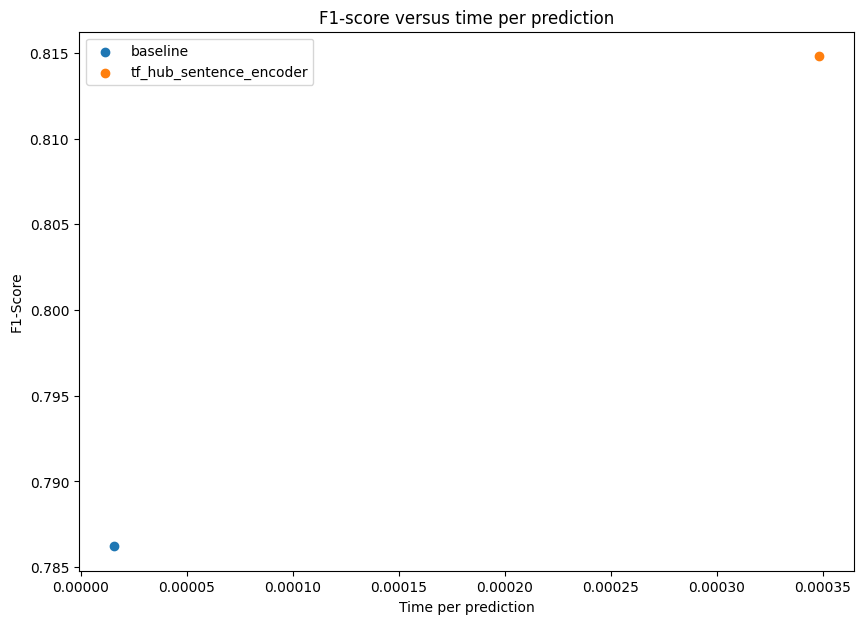

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-ideal-performance-speed-of-pred-tradeoff-highlighted.png)
*Ideal position for speed and performance tradeoff model (fast predictions with great results).*

## 📖 Extra-curriculum

To practice what you've learned, a good idea would be to spend an hour on 3 of the following (3-hours total, you could through them all if you want) and then write a blog post about what you've learned.

* For an overview of the different problems within NLP and how to solve them read through:
 * [A Simple Introduction to Natural Language Processing](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32)
 * [How to solve 90% of NLP problems: a step-by-step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)
* Read through the [word embeddings page on the TensorFlow website](https://www.tensorflow.org/tutorials/text/word_embeddings). Embeddings are such a large part of NLP. We've covered them throughout this notebook but extra practice would be well worth it. A good exercise would be to write out all the code in the guide in a new notebook.
* For more on RNN's in TensorFlow, read and reproduce [the TensorFlow RNN guide](https://www.tensorflow.org/guide/keras/rnn). We've covered many of the concepts in this guide, but it's worth writing the code again for yourself.
* Text data doesn't always come in a nice package like the data we've downloaded. So if you're after more on preparing different text sources for being with your TensorFlow deep learning models, it's worth checking out the following:
 * [TensorFlow text loading tutorial](https://www.tensorflow.org/tutorials/load_data/text).
  * [Reading text files with Python](https://realpython.com/read-write-files-python/) by Real Python.
* This notebook has focused on writing NLP code. For a mathematically rich overview of how NLP with Deep Learning happens, read [Standford's Natural Language Processing with Deep Learning lecture notes Part 1](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf).  
  * For an even deeper dive, you could even do the whole [CS224n](http://web.stanford.edu/class/cs224n/) (Natural Language Processing with Deep Learning) course.
* Great blog posts to read:
  * Andrei Karpathy's [The Unreasonable Effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) dives into generating Shakespeare text with RNNs.
  * [Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794) by Mauro Di Pietro. An overview of different techniques for turning text into numbers and then classifying it.
  * [What are word embeddings?](https://machinelearningmastery.com/what-are-word-embeddings/) by Machine Learning Mastery.
* Other topics worth looking into:
  * [Attention mechanisms](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/). These are a foundational component of the transformer architecture and also often add improvments to deep NLP models.
  * [Transformer architectures](http://jalammar.github.io/illustrated-transformer/). This model architecture has recently taken the NLP world by storm, achieving state of the art on many benchmarks. However, it does take a little more processing to get off the ground, the [HuggingFace Models (formerly HuggingFace Transformers) library](https://huggingface.co/models/) is probably your best quick start.
    * And now [HuggingFace even have their own course](https://huggingface.co/course/chapter1) on how their library works! I haven't done it but anything HuggingFace makes is world-class.

